<a id="toc_section"></a>
## Contents of this notebook

[**Raghav Rastogi**](https://www.kaggle.com/raghavrastogi75) 


* [Importing the libraries](#1)
* [Loading and transforming the images](#2)
* [Splitting the dataset](#3)
* [Taking a look at the normalised images](#4)
* [Creating Custom CNN network](#5)
* [Transfer learning - VGG16](#6)
* [Training Custom model](#7)
* [Training VGG16 model](#8)

In [1]:
# Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Importing the libraries <span id="1"></span>

In [2]:

import torchvision
import torch
import numpy as np
from torch import nn
from torchvision import transforms, models, datasets
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
import time
import pandas as pd
import torchvision.datasets as datasets
from IPython import display
import matplotlib.pyplot as plt
import torchvision.transforms


> #### Setting up the data folder

In [3]:
data_dir = "../input/cats-vs-dogs-1/PetImages"

# Loading and transforming the images <span id="2"></span>

> #### The images are augmented and normalised here. We use "ImageFolder" where we have the directory in the specific format of images divided by each class as folders and path being defined as the main folder.

In [4]:
data_transforms = transforms.Compose([transforms.Resize([64,64]),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                     ])

training_data = datasets.ImageFolder(data_dir,transform = data_transforms)



# Splitting the dataset  <span id="3"></span>

> #### I found out there are a lot are ways we can get the image data where the data is present as test and train directories, splitted by classes, or just a whole dump. This way below seems to be appropiate if get the format where the images are split by class as folders.

> #### Here we simply split the training data to training, test and validation and get the loaders. Loaders is the 4 dimensional tensor which has (batch_size, channel, width, height) format.

In [5]:
from torch.utils.data import SubsetRandomSampler

valid_size = 0.20
test_size = 0.10
# Split data into train and validation set
num_train = len(training_data)
indices = list(range(num_train))
np.random.shuffle(indices)
#print(indices)
split1 = int(np.floor(valid_size * num_train))
split2 = int(np.floor(test_size*num_train)) + split1
#print(split1,split2)
valid_idx, test_idx, train_idx = indices[:split1], indices[split1:split2],indices[split2:]

training_data1 = SubsetRandomSampler(train_idx)
valid_data1 = SubsetRandomSampler(valid_idx)
test_data1 = SubsetRandomSampler(test_idx)

training_loader = DataLoader(training_data, sampler = training_data1,batch_size = 25)
valid_loader = DataLoader(training_data, sampler = valid_data1, batch_size = 25)
test_loader = DataLoader(training_data, sampler = test_data1,batch_size = 25)

# Taking a look at the normalised images <span id="4"></span>

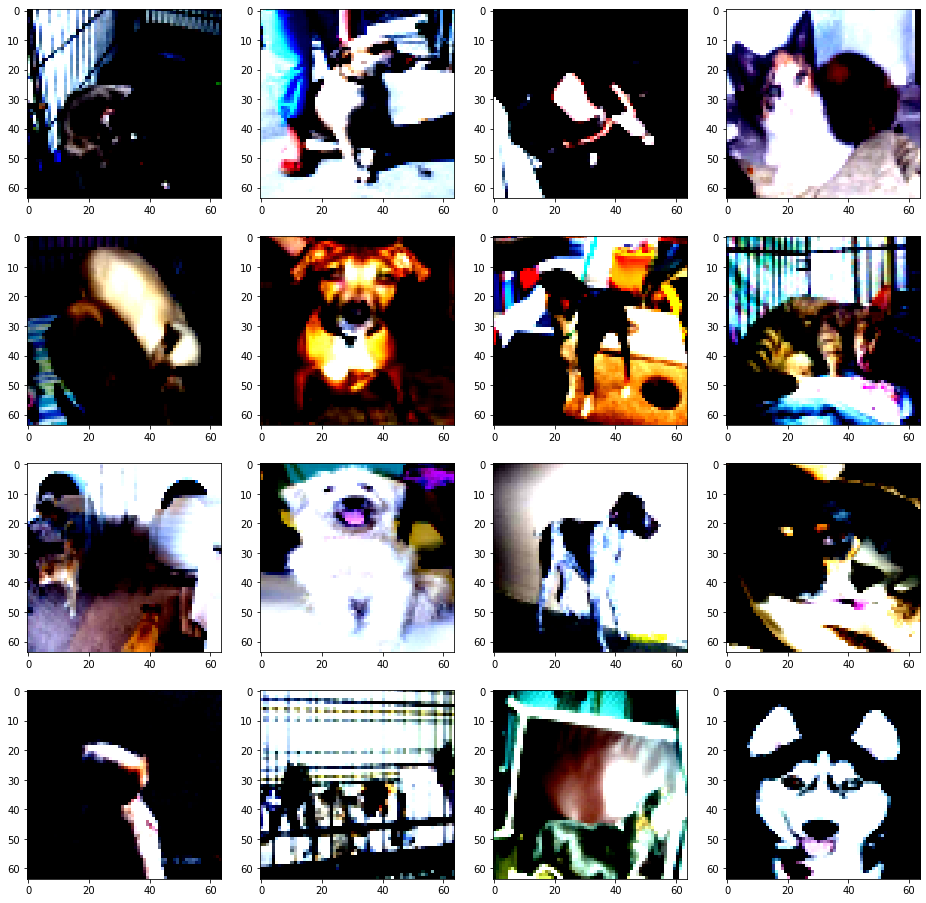

In [6]:
g = 1
rows = 4
cols = 4
figure = plt.figure(figsize=(16, 16))
for i,j in training_loader:    
    figure.add_subplot(rows, cols, g)
    for img in i:        
        img = img.swapaxes(0, 1)
        img = img.swapaxes(1, 2)
        plt.imshow(img, cmap="gray", interpolation='nearest', aspect='auto')        
        break
    g += 1    
    if g > 16:
        break
plt.show()       

# Creating Custom CNN network <span id="5"></span>

> ### Here are the key points when making a custom CNN model

> * The formula O = ((I - f + 2p)/s) + 1 is used to keep track of the output image size where O is the output image size, f is the kernal size, p is the padding, s is the stride.

> * Paramenters are calculated by ((NxNxC + 1)K) where N is the kernal size , C is the input channel and K is the output channels

> * In the model below the kernal_size of 3 and padding 1 means that the outout image size is equal to the input image size. Howvever, the MaxPool2d, which has the kernal_size of 2 and stride of 2 halves the height and width of the image.

> * Linear layer nodes are calculated by the product of input image size (NxN) and the out oput channels. Here it's 4x4x256

> * Parameters of the Linear layer is calculates by (N1+1)N2 where N1 is the number of nodes in the previous layer and N2 is the number of nodes in the current layer


In [7]:
device =  torch.device('cuda' if torch.cuda.is_available else 'cpu')

class CNNModel(nn.Module):
    def __init__(self, num_classes):

        super(CNNModel, self).__init__()
        self.features = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=3, padding=1), #input image 64x64 - Parameters = (3x3x3 + 1)*64
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2),
        nn.Conv2d(64,128, kernel_size = 3,padding = 1), #input image 32x32 - Parameters = (3x3x64 + 1)*128
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2),
        nn.Conv2d(128, 256, kernel_size=3, padding=1), #input image 16x16 - Parameters = (3x3x128 + 1)*256
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(256, 256, kernel_size=3, padding=1), #input image 8x8 - Parameters = (3x3x256 + 1)*256
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2) #output image 4x4
        )
        
        self.classifier = nn.Sequential(
        nn.Dropout(),
        nn.Linear(4*4*256,1024), #Parameters - (4x4x256 + 1)(1024)
        nn.ReLU(),
        nn.Dropout(),
        nn.Linear(1024, num_classes) #Parameters - (1024 + 1)(2)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    
    
model = CNNModel(num_classes=2)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr= 0.001)
model.to(device)

CNNModel(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=4096, out_features=1024, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=1024, out_features=2, bias=True)
  )
)

# Transfer learning - VGG16 <span id="6"></span>

> * #### This is pretty straight forward. We freeze the CNN part of the network and train the linear network completely with the images.

In [8]:
model1 = models.vgg16(pretrained=True)
for param in model1.parameters():
    param.requires_grad = False
model1.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
model1.classifier = nn.Sequential(nn.Flatten(),
nn.Linear(512, 128),
nn.ReLU(),
nn.Dropout(0.2),
nn.Linear(128, 2),
nn.Sigmoid())

criterion1 = nn.BCELoss()
optimizer1 = torch.optim.Adam(model1.parameters(), lr= 1e-3)

model1.to(device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Training the model

> * #### I found the code below pretty standard and being used a lot of times and we simply call it to train any tyoe of model.

In [9]:
import time

def train(model, optimizer, loss_fn, train_dl, val_dl, epochs=100, device='cpu'):

    print('train() called: model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device))

    history = {} # Collects per-epoch loss and acc like Keras' fit().
    history['loss'] = []
    history['val_loss'] = []
    history['acc'] = []
    history['val_acc'] = []

    start_time_sec = time.time()

    for epoch in range(1, epochs+1):

        # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
        model.train()
        train_loss         = 0.0
        num_train_correct  = 0
        num_train_examples = 0

        for batch in train_dl:

            optimizer.zero_grad()

            x    = batch[0].to(device)
            y    = batch[1].to(device)
            yhat = model(x)
            loss = loss_fn(yhat, y)

            loss.backward()
            optimizer.step()

            train_loss         += loss.data.item() * x.size(0)
            num_train_correct  += (torch.max(yhat, 1)[1] == y).sum().item()
            num_train_examples += x.shape[0]

        train_acc   = num_train_correct / num_train_examples
        train_loss  = train_loss / len(train_dl.dataset)


        # --- EVALUATE ON VALIDATION SET -------------------------------------
        model.eval()
        val_loss       = 0.0
        num_val_correct  = 0
        num_val_examples = 0

        for batch in val_dl:

            x    = batch[0].to(device)
            y    = batch[1].to(device)
            yhat = model(x)
            loss = loss_fn(yhat, y)

            val_loss         += loss.data.item() * x.size(0)
            num_val_correct  += (torch.max(yhat, 1)[1] == y).sum().item()
            num_val_examples += y.shape[0]

        val_acc  = num_val_correct / num_val_examples
        val_loss = val_loss / len(val_dl.dataset)


        if epoch == 1 or epoch % 10 == 0:
          print('Epoch %3d/%3d, train loss: %5.2f, train acc: %5.2f, val loss: %5.2f, val acc: %5.2f' % \
                (epoch, epochs, train_loss, train_acc, val_loss, val_acc))

        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['acc'].append(train_acc)
        history['val_acc'].append(val_acc)

    # END OF TRAINING LOOP


    end_time_sec       = time.time()
    total_time_sec     = end_time_sec - start_time_sec
    time_per_epoch_sec = total_time_sec / epochs
    print()
    print('Time total:     %5.2f sec' % (total_time_sec))
    print('Time per epoch: %5.2f sec' % (time_per_epoch_sec))

    return history

# Training Custom model <span id="7"></span>

In [10]:
history = train(model, optimizer,criterion, training_loader,valid_loader, epochs=10, device=device)

train() called: model=CNNModel, opt=Adam(lr=0.001000), epochs=10, device=cuda



/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch   1/ 10, train loss:  0.43, train acc:  0.66, val loss:  0.11, val acc:  0.73
Epoch  10/ 10, train loss:  0.16, train acc:  0.90, val loss:  0.07, val acc:  0.86

Time total:     954.90 sec
Time per epoch: 95.49 sec


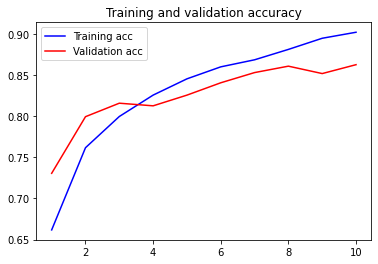

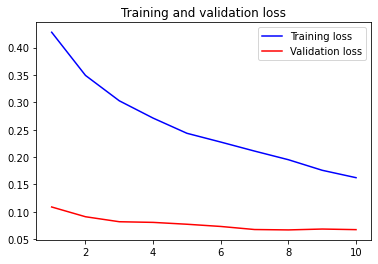

In [11]:

import matplotlib.pyplot as plt

acc = history['acc']
val_acc = history['val_acc']
loss = history['loss']
val_loss = history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


# Training VGG16 model <span id="8"></span>

In [12]:
history1 = train(model1, optimizer1,criterion, training_loader,valid_loader, epochs=10, device=device)

train() called: model=VGG, opt=Adam(lr=0.001000), epochs=10, device=cuda

Epoch   1/ 10, train loss:  0.30, train acc:  0.89, val loss:  0.08, val acc:  0.89
Epoch  10/ 10, train loss:  0.26, train acc:  0.95, val loss:  0.08, val acc:  0.90

Time total:     932.87 sec
Time per epoch: 93.29 sec


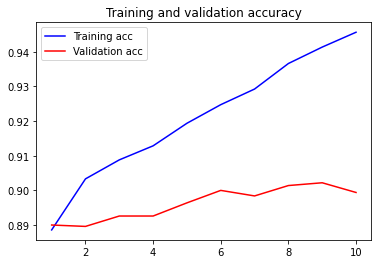

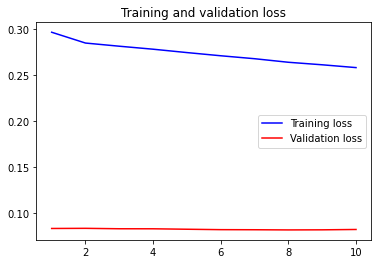

In [13]:
acc = history1['acc']
val_acc = history1['val_acc']
loss = history1['loss']
val_loss = history1['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()